# Latitude by Latitude Aquaplanet Theory
This applies the aquaplanet theory to each latitude individually and then does an area weighted average of each latitude in a given region.


In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

2023-05-12 09:07:32,080 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [68]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 3.5
tau_lw_warm = 6
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    try:
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    except KeyError:
        var_keep.remove('cape')     # not all datasets have cape variable
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
p_surface = float(ds[0].pfull) * 100

## Get datasets
Get one dataset for summer for each $\kappa$, in a given latitude bin: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in January, February or March.

In [69]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [83]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:19<00:00,  9.83s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

This shows the moist static energy percentiles (y-axis) corresponding to the average moist static energy of days exceeding the given temperature percentile.

The ocean plot shows good agreement with Byrne 2021, and this also shows that for land, in the warmer simulation, there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ over land, but in byrne 2021, we see a decrease.

In [84]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
# avoid 0 quantile as it gives weird results
quant_plot = np.arange(1, 100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)
n_lat = ds_all[0].temp.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
r_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in range(n_exp):
    temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
    sphum_mean[i] = ds_all[i].sphum.mean(dim='lon_time')
    mse_mean[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height).mean(dim='lon_time')
    r_mean[i] = 100 * (ds_all[i].sphum/sphum_sat(ds_all[i].temp, p_surface)).mean(dim='lon_time')

    temp_quant2[i] = ds_all[i].temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_all[i].sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    mse = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height)
    mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

## Ocean to Ocean Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

The scaling $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles, implying that the theory may be appropriate.

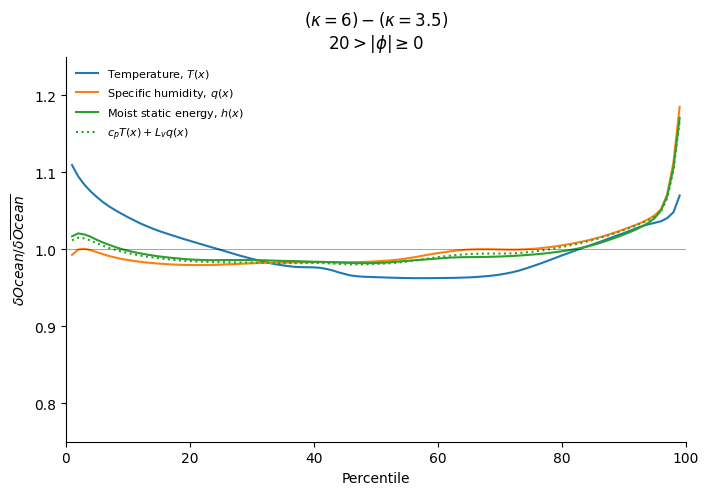

In [85]:
save_lambda_fig = False
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
labels = ['Temperature, $T(x)$','Specific humidity, $q(x)$', 'Moist static energy, $h(x)$']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean, sphum_mean, mse_mean]]
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    var_ratio = (var[1]-var[0])/delta_var_mean[i]
    ax.plot(quant_plot, np.average(var_ratio, axis=0, weights=lat_weights), label=labels[i])
ax.plot(quant_plot, np.average(np.diff(c_p * temp_quant2 + L_v * sphum_quant2, axis=0)[0]/
                               np.expand_dims(np.diff(c_p * temp_mean + L_v * sphum_mean, axis=0), axis=-1)[0],
                               axis=0, weights=lat_weights), color=default_colors[2], linestyle=':', label='$c_p T(x) + L_v q(x)$')
delta_mse_ratio = var_ratio
ax.hlines(1,0,100, color='k', linewidth=0.5, alpha=0.5)
ax.legend(frameon=True, framealpha=1, edgecolor='white', fontsize=8)
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta Ocean/\delta \overline{Ocean}$')
ax.set_ylim(0.75,1.25)
ax.set_xlim(0, 100)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Theory for $\delta T(p)$

### Form of MSE equation to start theory
From the above plot, we have $\delta h(p) = \delta \overline{h}$. Because this is an aquaplanet, higher temperatures are associated with higher moist static energies, as indicated by the $p^x$ vs $x$ plot.

Thus, we expect equation 10 in the paper: $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ should hold. In the plot below, we see that this is the case to within around $2%$ except for the extremely small percentiles, $p$.

So now we can obtain an equation for $\delta T(p)$, the temperature change of the percentile $p$ of temperature. This is simpler than what is done in the paper where it cannot assume $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ over land, so it instead considers the temperature change of days averaged over a given percentile, $x$, in temperature: $\delta T^x$.

Importantly, if we just consider $\delta T(p)$, we no longer have to think abut the problematic $\Delta h$ term.

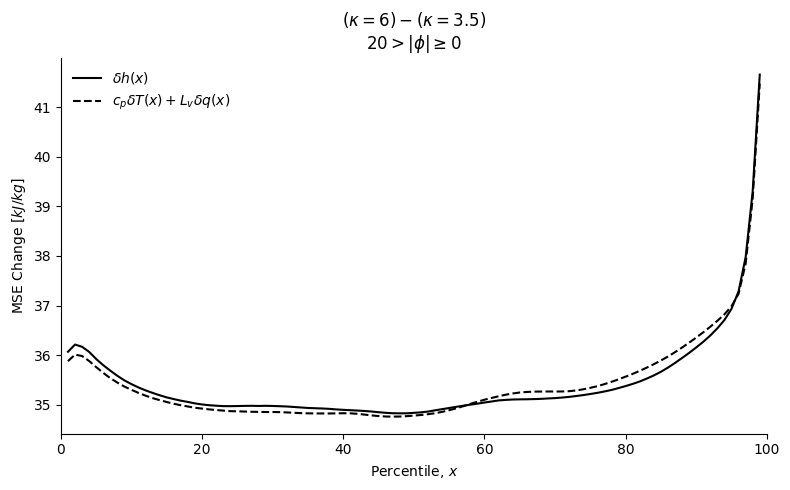

In [86]:
save_delta_mse_fig = False
fig_delta_mse, ax = plt.subplots(1,1, figsize=(8, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quant_plot, np.average(mse_quant2[1]-mse_quant2[0], axis=0, weights=lat_weights), label = '$\delta h(x)$', color='k')
ax.plot(quant_plot, np.average(c_p * (temp_quant2[1]-temp_quant2[0]) +
                               L_v * (sphum_quant2[1]-sphum_quant2[0]), axis=0, weights=lat_weights)/1000,
        label='$c_p \delta T(x) + L_v \delta q(x)$', color='k', linestyle='--')
ax.legend(frameon=False)
ax.set_xlabel('Percentile, $x$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax.set_xlim(0,100)
plt.tight_layout()

if save_fig or save_delta_mse_fig:
    fig_delta_mse.savefig(f"/Users/joshduffield/Desktop/delta_mse_{region.lower()}_{season}",
                          dpi=high_dpi if publish_fig else low_dpi)

## Theoretical Temperature Change
Below, we plot whether the theory can correctly predict the temperature change between adjacent simulations.

In [87]:
temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                        const_rh=True if method=='const_rh' else False,
                                        delta_mse_ratio=delta_mse_ratio[i:i+1] if 'lambda' in method else None,
                                        taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')


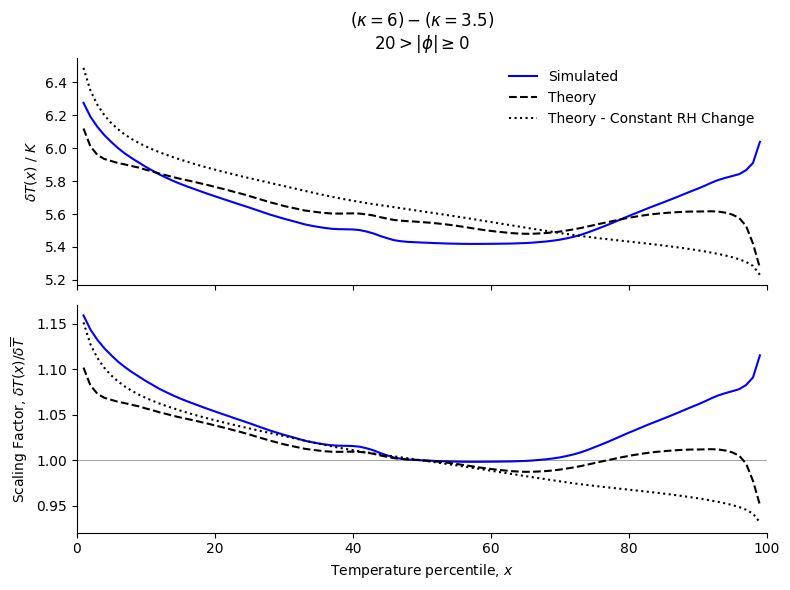

In [88]:
# take median as average rather than mean because theory does not predict change to mean temperature
av_quant_ind = np.where(quant_plot==50)[0]
save_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(temp_quant2[1]-temp_quant2[0], axis=0, weights=lat_weights), label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['const_rh'], axis=0, weights=lat_weights), color='k',
           label='Theory - Constant RH Change', linestyle=':')
ax[1].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[:, av_quant_ind],
                                  axis=0, weights=lat_weights), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['const_rh']/temp_diff_theory['const_rh'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].legend(frameon=False)
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T(x) = \gamma^T \delta \overline{T} + \gamma^{\Delta r} \delta (\overline{r}-r(x))$ and the dotted line is just $\gamma^T \delta \overline{T}$. The plots below show how these $\gamma$ factors vary with percentile.

In [89]:
gamma_t = np.zeros((n_lat, n_quant))
gamma_rdiff = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    all_gamma = get_gamma(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface)
    gamma_t[i] = all_gamma[0][0]
    gamma_rdiff[i] = all_gamma[1][0]

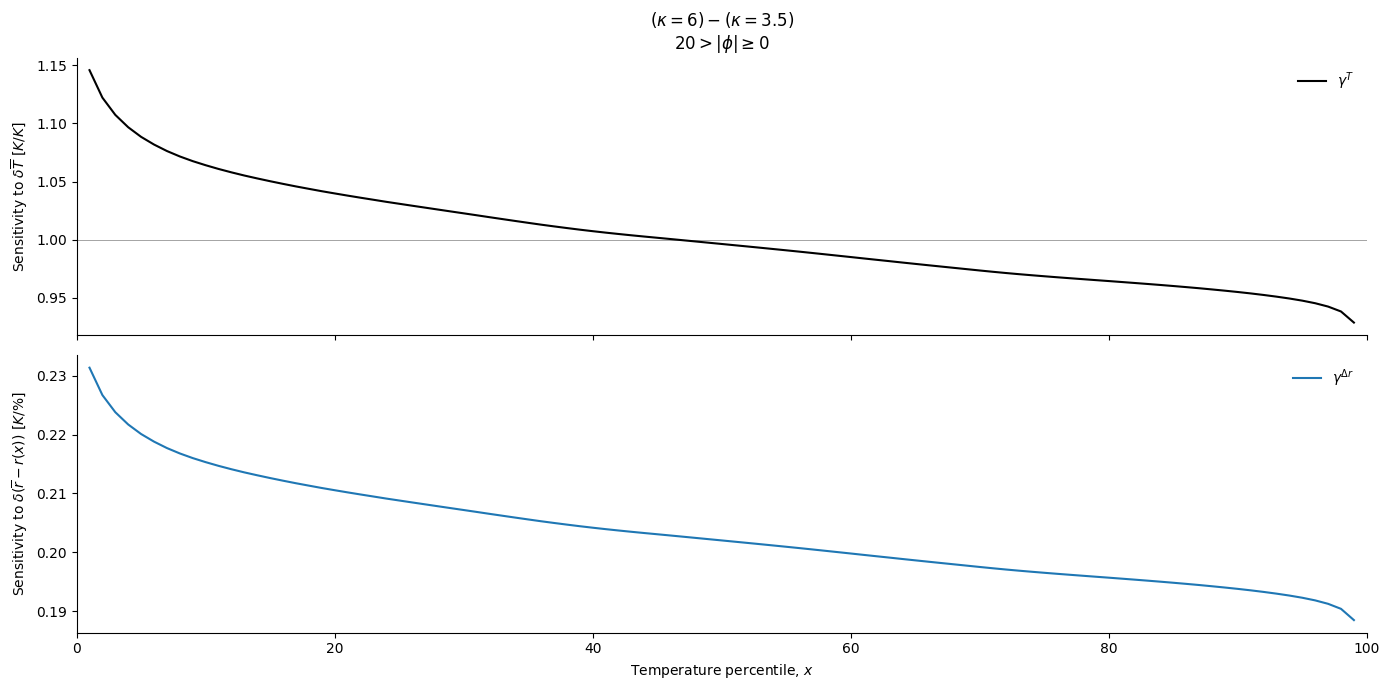

In [90]:
save_gamma_fig = False
fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(gamma_t, axis=0, weights=lat_weights), color='k', label='$\gamma^T$')
ax[1].plot(quant_plot, np.average(gamma_rdiff/100, axis=0, weights=lat_weights), color=default_colors[0], label='$\gamma^{\Delta r}$')
ax[0].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (\overline{r} - r(x))$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
plt.tight_layout()
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.
There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta Ocean/\delta \overline{Ocean}$ plot. This should be equal to 1.
    In the top plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown in the MSE Change plot. If this approximation was exact, we would expect the solid and dashed lines to match up exactly.
   In the top plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

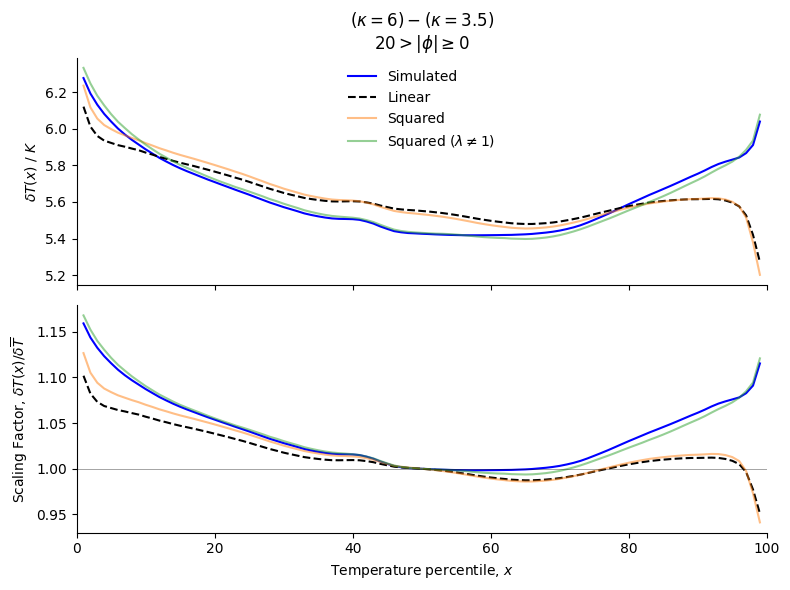

In [91]:
save_approx_fig = False
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].plot(quant_plot, np.average(temp_quant2[1]-temp_quant2[0], axis=0, weights=lat_weights), label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'], axis=0, weights=lat_weights), color='k', linestyle='--',
           label='Linear')
ax[0].plot(quant_plot, np.average(temp_diff_theory['squared'], axis=0, weights=lat_weights), color=default_colors[1],
           label='Squared', alpha=0.5)
ax[0].plot(quant_plot, np.average(temp_diff_theory['squared_lambda'], axis=0, weights=lat_weights), color=default_colors[2],
           label='Squared ($\lambda \\neq 1$)', alpha=0.5)
ax[1].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[:, av_quant_ind],
                                  axis=0, weights=lat_weights), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average(temp_diff_theory['linear']/temp_diff_theory['linear'][:, av_quant_ind], axis=0, weights=lat_weights),
           color='k', linestyle='--')
ax[1].plot(quant_plot, np.average(temp_diff_theory['squared']/temp_diff_theory['squared'][:, av_quant_ind], axis=0, weights=lat_weights),
           color=default_colors[1], alpha=0.5)
ax[1].plot(quant_plot, np.average(temp_diff_theory['squared_lambda']/temp_diff_theory['squared_lambda'][:, av_quant_ind],
                                  axis=0, weights=lat_weights), color=default_colors[2], alpha=0.5)

ax[1].hlines(1, -10, 100, color='k', alpha=0.5, linewidth=0.5)
ax[0].legend(frameon=False)
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$\n${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout()

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

## Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$.

Note, that this relative humidity is not a physical quantity. $r(x)$ is equal to the $x$ percentile of specific humidity, $q(x)$, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x))$.

In [92]:
r_mean2 = sphum_mean / sphum_sat(temp_mean, p_surface) * 100
r_quant2 = sphum_quant2 / sphum_sat(temp_quant2, p_surface) * 100

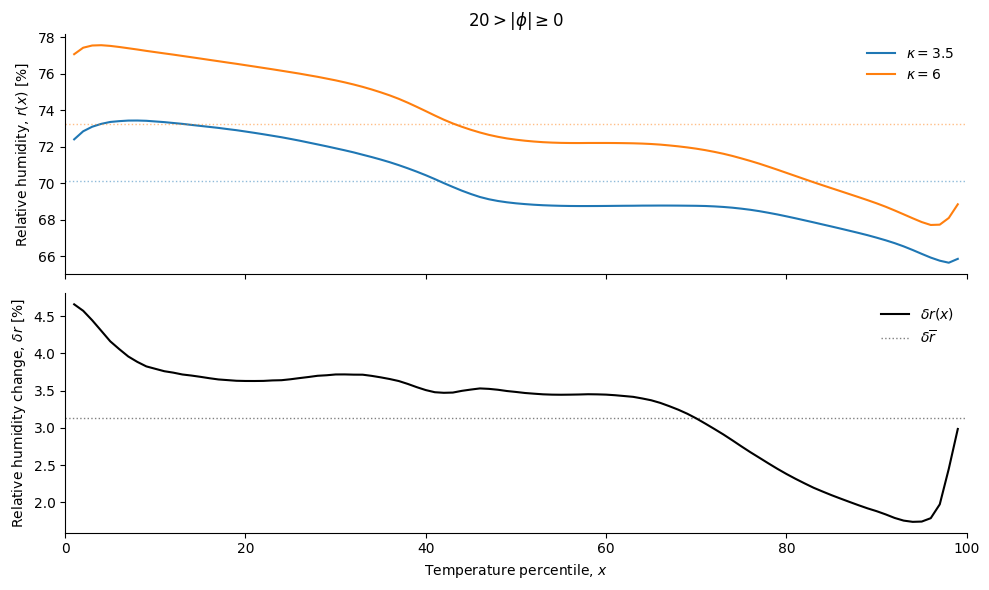

In [93]:
save_rh_fig = False
# choose which mean rh to plot - r_mean is mean over all RH values. r_mean2 is mean sphum divided by sphum_sat evaluated at mean temp.
# r_mean_use = r_mean
r_mean_use = r_mean2
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(r_quant2[i], axis=0, weights=lat_weights), color=default_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0].hlines(np.average(r_mean_use[i], weights=lat_weights), 0, 100, color=default_colors[i], linestyle=':', alpha=0.5, linewidth=1)
ax[1].plot(quant_plot, np.average(r_quant2[1]-r_quant2[0], axis=0, weights=lat_weights), color='k', label='$\delta r(x)$')
ax[1].hlines(np.average(r_mean_use[1]-r_mean_use[0], axis=0, weights=lat_weights), 0, 100, color='k', linestyles=':', label='$\delta \overline{r}$', alpha=0.5, linewidth=1)
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Relative humidity, $r(x)$ [%]')
ax[1].set_ylabel('Relative humidity change, $\delta r$ [%]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[0].set_title(f'${lat_max}>|\phi| \geq {lat_min}$')
# ax[0].set_ylim(58, 68)
# ax[1].set_ylim(0.2, 3.5)
plt.tight_layout()

if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}",
                dpi=high_dpi if publish_fig else low_dpi)

Below, I investigate the definition of mean relative humidity. As latitude increases, the mean across all relative humidities (black) becomes smaller than the mean specific humidity divided by the saturation specific humidity evaluated at the average temperature.

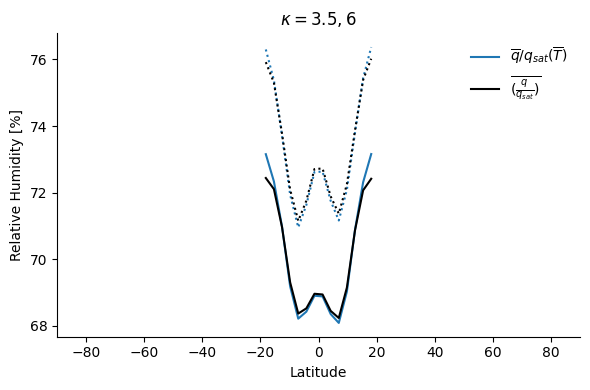

In [94]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_all[0].lat, r_mean2[0], color=default_colors[0], label='$\overline{q} / q_{sat}(\overline{T})$')
ax.plot(ds_all[0].lat, r_mean[0], color='k', label='$\overline{(\\frac{q}{q_{sat}})}$')
ax.plot(ds_all[0].lat, r_mean2[1], color=default_colors[0], linestyle=':')
ax.plot(ds_all[0].lat, r_mean[1], color='k', linestyle=':')
ax.set_xlim(-90,90)
ax.legend(frameon=False)
ax.set_ylabel('Relative Humidity [%]')
ax.set_xlabel('Latitude')
ax.set_title(f'$\kappa = {tau_lw[0]}, {tau_lw[1]}$')
plt.tight_layout();

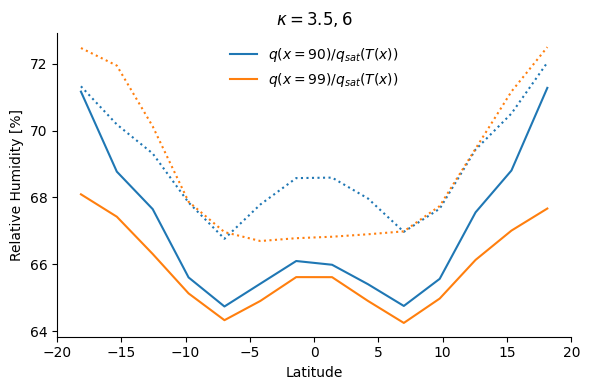

In [119]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(ds_all[0].lat, r_quant2[0, :, 89], color=default_colors[0], label='$q(x=90) / q_{sat}(T(x))$')
ax.plot(ds_all[0].lat, r_quant2[1, :, 89], color=default_colors[0], linestyle=':')
ax.plot(ds_all[0].lat, r_quant2[0, :, 98], color=default_colors[1], label='$q(x=99) / q_{sat}(T(x))$')
ax.plot(ds_all[0].lat, r_quant2[1, :, 98], color=default_colors[1], linestyle=':')
# ax.plot(ds_all[0].lat, rh_quant3[0,:,90]*100, color='k', label='$\\frac{q}{q_{sat}}(x)$')
# ax.plot(ds_all[0].lat, r_quant2[1, :, 90], color=default_colors[0], linestyle=':')
# ax.plot(ds_all[0].lat, rh_quant3[1,:,90]*100, color='k', linestyle=':')
ax.set_xlim(-lat_max,lat_max)
ax.legend(frameon=False)
ax.set_ylabel('Relative Humidity [%]')
ax.set_xlabel('Latitude')
ax.set_title(f'$\kappa = {tau_lw[0]}, {tau_lw[1]}$')
plt.tight_layout();

## Percentile vs average around a percentile
When computing $h_{FT}^*(p)$, rather than just considering a single day for each percentile, we took the average of all days around a given percentile e.g. for $x=90$, we consider average over all days with a temperature percentile between $89.5 < x \leq 90.5$. We do a sanity check below to make sure this doesn't change the temperature and relative humidity terms shown above too much.

In the plots below, $p$ refers to the percentile for that quantity e.g. $h(p)$ is the percentile $p$ of MSE. $x$ refers to the average over all days between $x-0.5$ and $x+0.5$ percentile of a given quantity e.g. $h(x_T=90)$ is the MSE averaged over all days with temperature between the 89.5 and 90.5 percentile.

In [114]:
# Get values averaged around a temperature percentile, rather than exactly on it.
temp_quant3 = np.zeros_like(temp_quant2)
sphum_quant3 = np.zeros_like(sphum_quant2)
r_quant3 = np.zeros_like(sphum_quant2)     # this is average over all individual relative humidities
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                # Take percentile to be temperature percentile
                use_ind = get_quant_ind(ds_all[i].temp[k], quant, 0.5, 0.5)
                temp_quant3[i, k, j] = ds_all[i].temp[k, use_ind].mean()
                sphum_quant3[i, k, j] = ds_all[i].sphum[k, use_ind].mean()
                r_quant3[i, k, j] = (ds_all[i].sphum[k, use_ind]/sphum_sat(ds_all[i].temp[k, use_ind], p_surface)).mean()
                pbar.update(1)

100%|██████████| 2772/2772 [00:24<00:00, 113.92it/s]


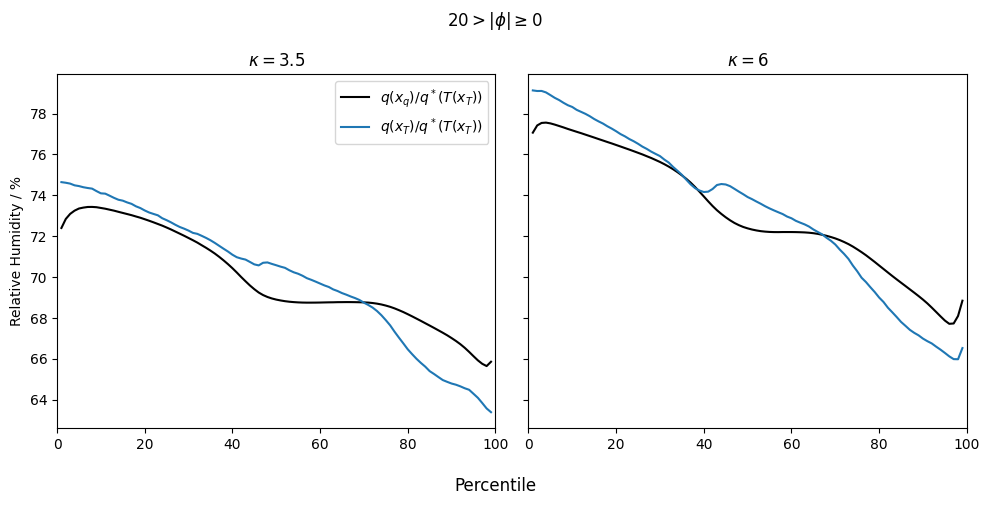

In [103]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].plot(quant_plot, 100*np.average(sphum_quant2[i]/sphum_sat(temp_quant2[i], p_surface), axis=0, weights=lat_weights),
               color='k', label='$q(x_q)/q^*(T(x_T))$')
    ax[i].plot(quant_plot, 100*np.average(sphum_quant3[i]/sphum_sat(temp_quant3[i], p_surface), axis=0, weights=lat_weights),
               color=default_colors[0], label='$q(x_T)/q^*(T(x_T))$')
    # ax[i].plot(quant_plot, 100*np.average(rh_quant3[i], axis=0, weights=lat_weights),
    #        color=default_colors[1], label='$r(x_T)$')
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
ax[0].legend()
ax[0].set_ylabel('Relative Humidity / %')
ax[0].set_xlim(0,100)
fig.supxlabel('Percentile')
fig.suptitle(f'${lat_max}>|\phi| \geq {lat_min}$')
plt.tight_layout();

In the plot below, I show that the MSE change deviates a lot from the actual MSE change if I use the temperature percentile for the tropics. Away from the tropics though, there doesn't seem to be much difference.

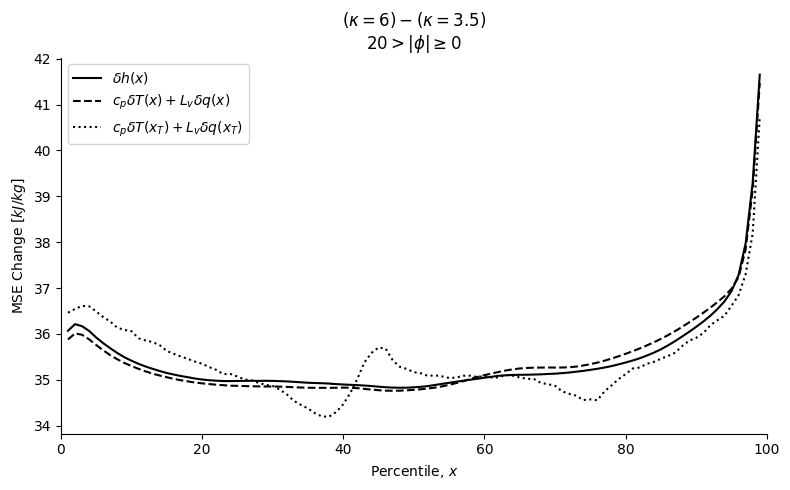

In [97]:
fig = copy.deepcopy(fig_delta_mse)
ax = fig.gca()
ax.plot(quant_plot, np.average(c_p * (temp_quant3[1]-temp_quant3[0]) + L_v * (sphum_quant3[1]-sphum_quant3[0]),
                               axis=0, weights=lat_weights)/1000,
        label='$c_p \delta T(x_T) + L_v \delta q(x_T)$', color='k', linestyle=':')
ax.legend()
fig